# Speed Dating Experiment

This project uses data from the [speed dating experiment dataset](https://www.kaggle.com/annavictoria/speed-dating-experiment) on Kaggle. Using information about daters and their partners, can we predict whether they wanted to see each other again?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

# Some warnings tend to pop up during grid search
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pre-wrangled, using the steps below
data = pd.read_csv('Speed Dating Data.csv', encoding='latin-1')

print(data.shape[0], 'observations and', data.shape[1], 'features')

8378 observations and 195 features


In [3]:
# What kind of data are we dealing with?
data.dtypes.value_counts()

float64    174
int64       13
object       8
dtype: int64

In [4]:
# Men (1) and women (0)
data.groupby('iid').mean().gender.value_counts()

1.0    277
0.0    274
Name: gender, dtype: int64

In [5]:
# What percentage of pairs resulted in a match?
data['match'].value_counts(normalize=True)

0    0.835283
1    0.164717
Name: match, dtype: float64

About 16% of pairs resulted in a match -- a bit higher than I expected!

Using the Synthetic Minority Oversampling Technique (SMOTE) inside of the **`imbalanced-learn`** library can create new data points that resemble existing ones (using a k-nearest neighbors algorithm). I tried this in an earlier draft of the project, but it didn't lead to a significant increase in my model's performance. Trying it, however, was a great learning experience and gave me a new tool in my machine learning toolbox!

In [6]:
# Getting a rough feel for how the data looks
data.head(1)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


This dataset contains multiple speed dating events, and a few measured people's personalities differently.

In all cases, participants had to rate how important different qualities in a parter were (such as ambition, sincerity, intelligence, etc.).

Some events gave people 100 points to distribute over these qualities, while others simply asked people to rate their importance from 1-10. Upon extensive testing, I found that removing the less-common scoring method resulted in a better model. Conversely, trying to normalize both methods didn't work quite as well.

In [6]:
# Waves 6-11 rated importance, others allocated 100 points
points = (data.wave != 6 ) &\
    (data.wave != 7 ) &\
    (data.wave != 8 ) &\
    (data.wave != 9 ) &\
    (data.wave != 10 ) &\
    (data.wave != 11 )

data = data[points]

**Certain features are a little too similar to the target variable (whether there was a match). I'm electing to remove them, because I don't think it's interesting to predict matches based, for instance, on someone's response to the question, "How attracted are you to this person?" (That's too easy!)**

**The data I *will* use here is the average rating of each participant, as determined by how often his or her partners wanted to see them again. This gives us a rough estimate of each person's desirability, which is important since birds of a feather flock together.**

**Similarly, I'll look at how "choosy" someone was -- were they interested in every person they met, or hardly anyone? I think this data is fair game for the machine learning task, since a dating website would have similar statistics.**

In [7]:
desirability = data.groupby('iid').mean()['dec_o'].to_dict()
data['desirability'] = data['iid'].map(desirability)

choosiness = data.groupby('iid').mean()['dec'].to_dict()
data['choosiness'] = data['iid'].map(choosiness)

In [8]:
match_corrs = data.select_dtypes(include=[np.number])\
.corrwith(data.match)\
.sort_values(ascending=False)

match_corrs = match_corrs[match_corrs > .25].index

data = data.dropna(subset=['id', 'pid'], axis=0)

for i in match_corrs[1:]:
    del data[i]

# Other columns that are too predictive
del data['int_corr']
del data['them_cal']
del data['you_call']

del data['field'] # redundant

match_corrs

Index(['match', 'dec_o', 'dec', 'like_o', 'like', 'fun_o', 'fun', 'shar_o',
       'shar', 'attr_o', 'attr', 'prob_o', 'prob'],
      dtype='object')

This is a dirty dataset that needs to be cleaned. The first thing we'll do is fix the columns that are strings but should be numbers. I'm replacing the null values with -100 in anticipation of using a tree-based algorithm. A quick cross-validation showed that this strategy is better than using the feature's mean or median value.

In [9]:
def fix_numeric(col, df=data, median=False):
    try:
        df[col] = df[col].str.replace(',', '')
    except:
        print('Column is not a string!')
    
    df[col] = df[col].astype(float)
    
    if median:
        df[col] = df[col].fillna(data.fillna.median())
    
    else:
        df[col] = df[col].fillna(-100)
    
    return df

for i in 'zipcode mn_sat tuition income'.split():
    data = fix_numeric(i)

Next we'll convert all string-based columns to lower case so we can process the data more reliably.

In [10]:
for i in data.columns:
    if data[i].dtype == "O":
        data[i] = data[i].str.lower()
        print(i, end=', ')

undergra, from, career, 

# Benchmark

ROC-AUC has turned out to be the best metric to use for this project, and a naive predictor will always obtain a ROC-AUC score of 0.5. Nonetheless, let's run to the code to make it official.

In [11]:
from sklearn.dummy import DummyClassifier

data_benchmark = pd.get_dummies(data)
data_benchmark.fillna(data_benchmark.median(), inplace=True)

xbench = data_benchmark.drop('match', axis=1)
ybench = data_benchmark['match']

dum = DummyClassifier(strategy='constant', constant=1)

cvs = cross_val_score(dum, xbench, ybench, scoring='roc_auc', cv=5)

benchmark_score = cvs.mean()

print('Naive Benchmark:', benchmark_score)

Naive Benchmark: 0.5


# Feature Engineering
And now we'll engineer some new features based on people's responses to the open-ended questions.

I examined people's responses to the three features "from," "undergra(d)," and "career," and combined some of the more common answers into a single variable. First we set the default value to zero, and then overwrite it with a 1 when a response matches the strings listed.

In [12]:
data['from_new_england'] = 0
for i in 'massachu connect rhode vermont vt hampsh maine boston cambridge'.split():
    data['from_new_england'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                                        data['from_new_england'])
    
data['from_china'] = 0
for i in 'china beijing shanghai hong taiwan'.split():
    data['from_china'] = np.where((data['from'].str.contains(i)) |\
                                  (data['undergra'].str.contains(i)), 1,
                                  data['from_china'])

data['from_india'] = 0
for i in 'india delhi bangalore'.split():
    data['from_india'] = np.where((data['from'].str.contains(i)) |\
                                  (data['undergra'].str.contains(i)), 1,
                                  data['from_india'])
    
data['from_europe'] = 0
for i in 'europe germany italy france spain poland portugal netherlands holland sweden switz greece belgium paris rome'.split():
    data['from_europe'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                                   data['from_europe'])

data['from_uk'] = 0
for i in 'london england uk britain scotland ireland kingdom oxford'.split():
    data['from_uk'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                               data['from_uk'])

data['from_ny'] = 0
for i in ['new york', 'ny']:
    data['from_ny'] = np.where((data['from'].str.contains(i)) |\
                               (data['undergra'].str.contains(i)), 1,
                               data['from_ny'])

data['from_nj'] = 0
for i in ['new jersey', 'nj']:
    data['from_nj'] = np.where((data['from'].str.contains(i)) |\
                               (data['undergra'].str.contains(i)), 1,
                               data['from_nj'])

data['from_california'] = 0
for i in 'cali diego francisco jose davis sacramento oakland clara angeles ucla stanford berkeley alto torrance'.split():
    data['from_california'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                                       data['from_california'])
    
data['from_texas'] = 0
for i in 'texas tx dallas austin houston dfw antonio'.split():
    data['from_texas'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                                  data['from_texas'])
    

Now let's do something similar with careers.

In [13]:
data['career_education'] = 0
for i in 'professor teach academ educ'.split():
    data['career_education'] = np.where(data['career'].str.contains(i),
                                        1, data['career_education'])

data['career_law'] = 0
for i in 'law attorney legal defender counsel'.split():
    data['career_law'] = np.where(data['career'].str.contains(i),
                                  1, data['career_law'])

data['career_medicine'] = 0
for i in 'doctor dr physician md medical m.d. cardio dentist surg'.split():
    data['career_medicine'] = np.where(data['career'].str.contains(i),
                                       1, data['career_medicine'])

data['career_business'] = 0
for i in 'business mba m.b.a. consult manage ceo c.e.o. entre finance venture market strategy invest bank equity'.split():
    data['career_business'] = np.where(data['career'].str.contains(i),
                                       1, data['career_business'])
    
data['career_science'] = 0
for i in 'sci research biolo chemi'.split():
    data['career_science'] = np.where(data['career'].str.contains(i),
                                      1, data['career_science'])

data['career_gov'] = 0
for i in 'gov diplo poli'.split():
    data['career_gov'] = np.where(data['career'].str.contains(i),
                                  1, data['career_gov'])


And schools. The data is from Columbia, so I thought it deserved its own feature. Other than that, I think it's only the other Ivy League schools that are noteworthy here (we've already used schools to determine where people are from).

In [14]:
data['school_columbia'] = 0
for i in 'columbia'.split():
    data['school_columbia'] = np.where(data['undergra'].str.contains(i),
                                       1, data['school_columbia'])

# Ivy league and other prestigious schools
data['school_ivy'] = 0
for i in 'dartmouth cornell princeton penn yale brown harvard stanford mit berkeley oxford'.split():
    data['school_ivy'] = np.where(data['undergra'].str.contains(i),
                                  1, data['school_ivy'])

Time to dummify our remaining data and do some final tidying up.

408      dummy_bombay, india
412    dummy_bowdoin college
430              dummy_china
656        dummy_engineering
716           dummy_medicine
dtype: object

In [20]:
# Dummify
data = pd.get_dummies(data, prefix='dummy')

# Some Stackoverflow code to fix duplicate column names
cols = pd.Series(data.columns)

for dup in cols[cols.duplicated()]:
    cols[data.columns.get_loc(dup)] =\
    [dup+'.'+str(d_idx) if d_idx!=0 else dup for d_idx in range(data.columns.get_loc(dup).sum())]

data.columns = cols

data.shape

(5761, 822)

We have a lot of null values in this dataset. After some experimentation, I found that predicting them using a regressor was the best strategy. The main thing we have to be careful about is not using our target variable to regress these values -- that would be looking into the future and would contaminate our dataset.

I chose to use a k-neighbors regressor because it's computationally cheap and there is a lot of data to process.

In [21]:
# Just a sample of how much missing data we have.
data.isnull().sum().sort_values(ascending=False)[:10]

num_in_3    5278
numdat_3    5067
shar4_3     4271
attr7_3     4271
sinc7_3     4271
intel7_3    4271
fun7_3      4271
amb7_3      4271
attr4_3     4271
sinc4_3     4271
dtype: int64

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Get null columns
null_cols = data.isnull().sum()
null_cols = list(null_cols[null_cols != 0].index)

for i in null_cols:
    #print(i, 'has', data[i].isnull().sum(), 'missing values')
    x = data.fillna(data.mean()).drop(['match', 'id'], axis=1)
    y = x.pop(i)
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)
    reg = KNeighborsRegressor()
    reg.fit(xtrain, ytrain)      
    pred = reg.predict(xtest)
    r2 = r2_score(ytest, pred)
    
    # If we can reasonably predict these values, do so
    if r2 > .20:
        #print('regressing', i, 'with an r2 of', round(r2, 3))
        data['predicted'] = reg.predict(data.fillna(data.median()).drop([i, 'match', 'id'], axis=1))
        data[i] = np.where(data[i].isnull(), data['predicted'], data[i])
        del data['predicted']
    
    # Otherwise, just take the median
    else:
        #print('averaging', i)
        data[i] = data[i].fillna(data[i].median())
    #print()

KeyboardInterrupt: 

Let's add more features. We're vastly increasing the dimensionality of the data, but we'll try dimensionality reduction techniques later and cross-validate them.

In [ ]:
def get_partner_data(pid, col):
    '''Looks up the person's partner and adds their data
    as new features. If the partner ID doesn't exist,
    returns a -1.'''
    try:
        partner = data[data['iid'] == pid].head(1)[col].iloc[0]
        if partner:
            return partner
        else:
            return -1
    except:
        return -1

# Income (where income data is available, take the log difference)
data['partner_income'] = data['pid'].apply(get_partner_data, col='income')
data['income_difference'] = np.where((data.partner_income == -1) |\
                                     (data.income == -1),
                                     -1, np.log1p(np.abs(data.income - data.partner_income)))

# Age
data['age'].fillna(data['age'].median(), inplace=True)
data['age_o'].fillna(data['age_o'].median(), inplace=True)
data['age_difference'] = data['age'] - data['age_o']

In [ ]:
# This is important: compare the each person's overall desirability to their partner's.

data['partner_desirability'] = data['pid'].apply(get_partner_data, col='desirability')

data['des_diff'] = data['desirability'] - data['partner_desirability']

# Also for Choosiness

data['partner_choosiness'] = data['pid'].apply(get_partner_data, col='choosiness')

data['choose_diff'] = data['choosiness'] - data['partner_choosiness']

There was a *lot* of data gathered at these events; probably more than necessary. Not only were participants rating the importance of these qualities in others, but they also:

- Rated themselves
- Rated how they think *others* might score them
- Updated their ratings midway through the speed-dating event

I believe the fundamentally important information is how a partner stacked up against someone's expectations. So we'll definitely calculate that. But we'll also do it in **two** ways, because people updated their self-ratings midway through.

It's complicated and I don't agree with the study's methodology, but we should make use of all the data we have.

In [ ]:
# Attractiveness
data['partner_attractiveness'] = data['pid'].apply(get_partner_data, col='attr3_1')
data['attr_expectations'] = (10*data['attr1_1']/data['attr1_1'].max()) -\
                                     data['partner_attractiveness']
data['partner_attractiveness_2'] = data['pid'].apply(get_partner_data, col='attr5_1')
data['attr_expectations_2'] = (10*data['attr1_1']/data['attr1_1'].max()) -\
                                       data['partner_attractiveness_2']

# Intelligence
data['partner_intelligence'] = data['pid'].apply(get_partner_data, col='intel3_1')
data['intel_expectations'] = (10*data['intel1_1']/data['intel1_1'].max()) -\
                                     data['partner_intelligence']
data['partner_intelligence_2'] = data['pid'].apply(get_partner_data, col='intel5_1')
data['intel_expectations_2'] = (10*data['intel1_1']/data['intel1_1'].max()) -\
                                       data['partner_intelligence_2']

# Fun
data['partner_fun'] = data['pid'].apply(get_partner_data, col='fun3_1')
data['fun_expectations'] = (10*data['fun1_1']/data['fun1_1'].max()) -\
                                     data['partner_fun']
data['partner_fun_2'] = data['pid'].apply(get_partner_data, col='fun5_1')
data['fun_expectations_2'] = (10*data['fun1_1']/data['fun1_1'].max()) -\
                                       data['partner_fun_2']

# Ambitious
data['partner_ambition'] = data['pid'].apply(get_partner_data, col='amb3_1')
data['amb_expectations'] = (10*data['amb1_1']/data['amb1_1'].max()) -\
                                     data['partner_ambition']
data['partner_ambition_2'] = data['pid'].apply(get_partner_data, col='amb5_1')
data['amb_expectations_2'] = (10*data['amb1_1']/data['amb1_1'].max()) -\
                                       data['partner_ambition_2']

# Sincerity
data['partner_sincerity'] = data['pid'].apply(get_partner_data, col='sinc3_1')
data['sinc_expectations'] = (10*data['sinc1_1']/data['sinc1_1'].max()) -\
                                     data['partner_sincerity']
data['partner_sincerity_2'] = data['pid'].apply(get_partner_data, col='sinc5_1')
data['sinc_expectations_2'] = (10*data['sinc1_1']/data['sinc1_1'].max()) -\
                                       data['partner_sincerity_2']

We're going to calculate expectations one last way: by binning traits into "above average" and "below average" and seeing how each pair stacks up. We'll assign a "1" when a partner meets or exceeds someone's expectations, and a "0" otherwise.

I'm also going to try comparing ambition importance to the partner's socioeconomic status (zip code average income). Maybe this will be more important than simply whether someone *says* they're ambitious.

In [ ]:
# Measuring expectations one more way

data['attr_above_avg'] = np.where(data['partner_attractiveness'] > data['partner_attractiveness'].mean(),
                                  1, 0)
data['attr_imp_above_avg']= np.where(data['attr1_1'] > data['attr1_1'].mean(),
                                     1, 0)
data['attr_match'] = np.where(data['attr_above_avg'] >= data['attr_imp_above_avg'],
                             1, 0)

data['sinc_above_avg'] = np.where(data['partner_sincerity'] > data['partner_sincerity'].mean(),
                                  1, 0)
data['sinc_imp_above_avg']= np.where(data['sinc1_1'] > data['sinc1_1'].mean(),
                                     1, 0)
data['sinc_match'] = np.where(data['sinc_above_avg'] >= data['sinc_imp_above_avg'],
                             1, 0)

data['int_above_avg'] = np.where(data['partner_intelligence'] > data['partner_intelligence'].mean(),
                                  1, 0)
data['int_imp_above_avg']= np.where(data['intel1_1'] > data['intel1_1'].mean(),
                                     1, 0)
data['int_match'] = np.where(data['int_above_avg'] >= data['int_imp_above_avg'],
                             1, 0)

data['fun_above_avg'] = np.where(data['partner_fun'] > data['partner_fun'].mean(),
                                  1, 0)
data['fun_imp_above_avg']= np.where(data['fun1_1'] > data['fun1_1'].mean(),
                                     1, 0)
data['fun_match'] = np.where(data['fun_above_avg'] >= data['fun_imp_above_avg'],
                             1, 0)

In [ ]:
# Ambition (recall we're doing this one differently)

# Temporarily replace missing values with the median
data['income_temp'] = np.where(data['income'] == -100, data['income'].median(), data['income'])

data['income_above_avg']= np.where(data['income_temp'] > data['income_temp'].median(), 1, 0)
data['partner_income_above_avg'] = data['pid'].apply(get_partner_data, col='income_above_avg')

data['amb_imp_above_avg'] = np.where(data['amb1_1'] > data['amb1_1'].mean(), 1, 0)

data['amb_match'] = np.where(data['partner_income_above_avg'] >= data['amb_imp_above_avg'],
                             1, 0)
del data['income_temp']

Now let's add some more information about people's partners. If a participant and their partner both went to the same school, are from the same place, or have similar career ambitions, we'll assign a "1" for that feature, otherwise we'll assign a "0."

In [ ]:
cols = data.columns

for i in cols:
    if 'from_' in i:
        data['partner_loc'] = data['pid'].apply(get_partner_data, col=i)
        data['both_' + i] = np.where((data[i] == 1) & (data['partner_loc'] == 1), 1, 0)
        del data['partner_loc']
        
for i in cols:
    if 'school_' in i:
        data['partner_edu'] = data['pid'].apply(get_partner_data, col=i)
        data['both_' + i] = np.where((data[i] == 1) & (data['partner_edu'] == 1), 1, 0)
        del data['partner_edu']
        
for i in cols:
    if 'career_' in i:
        data['partner_car'] = data['pid'].apply(get_partner_data, col=i)
        data['both_' + i] = np.where((data[i] == 1) & (data['partner_car'] == 1), 1, 0)
        del data['partner_car']

And now do something similar for hobbies.

In [ ]:
hobbies = ['go_out', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
 'movies', 'concerts', 'music', 'shopping', 'yoga']

for i in hobbies:
    data['partner_' + i] = data['pid'].apply(get_partner_data, col=i)
    data[i + '_in_common'] = np.where((data[i] > 7) & (data['partner_' + i] > 7), 1, 0)
    del data['partner_' + i]

Dimensionality is increasing quickly. Let's remove dummies where only a single person has a "1." My testing showed that this improved the model's performance.

In [ ]:
counts =\
data.groupby('iid').mean().sum(axis=0).sort_values()

deleted = []

for i in counts[counts < 2].index:
    if 'dummy_' in i:
        deleted.append(i)
        del data[i]

# Fix anything that got counted twice
for i in data.columns:
    if 'dummy_' in i:
        data[i] = np.where(data[i] >= 1, 1, 0)

In [ ]:
# Nearly 500 features removed. Not bad!
print('Deleted:', len(deleted))
print('Data shape:', data.shape)

After several dozen hours of grid searching and trying to improve my model's performance, I finally went all-out and just appended *all* the partner data. My intuition that feature selection and machine learning would figure out what to do with this additional data was correct.

I would generally be more selective in situations like this, but I cross-validated and this strategy worked.

In [ ]:
cols = data.drop(['match', 'pid'], axis=1).columns
for i in cols:
    try:
        data['pid'].apply(get_partner_data, col=i)
    except:
        continue

One last feature to engineer: processing zip code data.

This was an interesting case. Originally, I planned to compare zip codes to see how far apart people grew up. It would be something along the lines of:

- 5 digits in common: Same neighborhood
- 4 digits in common: Same city
- 3 digits in common: Same state

and so on. But what I found was that comparing zip codes like this actually *reduced* our model's accuracy, while simply breaking down zip code components and adding the partner's data improved it.

So the code below might seem odd, but it leads to a marginal improvement in performance.

In [ ]:
data['zipcode'] = data['zipcode'].astype(str)
data['zip_5'] = (data['zipcode'].str[:5]).astype(float)
data['zip_4'] = (data['zipcode'].str[:4]).astype(float)
data['zip_3'] = (data['zipcode'].str[:3]).astype(float)
data['zip_2'] = (data['zipcode'].str[:2]).astype(float)
del data['zipcode']

data['partner_zip'] = data['pid'].apply(get_partner_data, col='zipcode')
data['partner_zip'] = data['partner_zip'].astype(str)
data['partner_zip_5'] = (data['partner_zip'].str[:5]).astype(float)
data['partner_zip_4'] = (data['partner_zip'].str[:4]).astype(float)
data['partner_zip_3'] = (data['partner_zip'].str[:3]).astype(float)
data['partner_zip_2'] = (data['partner_zip'].str[:2]).astype(float)
del data['partner_zip']

One last thought I had was to check the correlations between columns and make sure no features were too similar to one another. I did this with the for-loop below, but ultimately decided not to remove any features.

In [30]:
cols = data.columns

for i in cols:
    for j in cols:
        if i > j:
            corr = np.corrcoef(data[i], data[j])[0,1]
            if corr > .90:
                print(i, j)

idg id
wave iid
wave pid
pid iid
school_columbia both_school_columbia
partner_income_above_avg amb_match
both_school_ivy both_school_columbia
zip_4 zip_3
zip_4 zip_2
zip_3 zip_2


In [31]:
print('Data shape:', data.shape)

Data shape: (5761, 419)


In [32]:
# Checkpoint
data.to_csv('Speed Dating Data Processed.csv')

# Preliminary Visualizations

In [2]:
data = pd.read_csv('Speed Dating Data Processed.csv', encoding='latin-1')

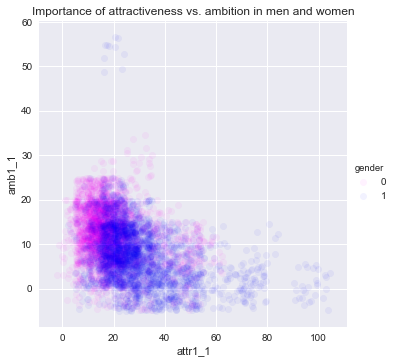

In [33]:
sns.lmplot("attr1_1", "amb1_1",
           data=data, hue='gender', fit_reg=False,
           x_jitter=5, y_jitter=5,
           palette=['magenta', 'blue'],
           scatter_kws={'alpha':.05})

plt.title('Importance of attractiveness vs. ambition in men and women');

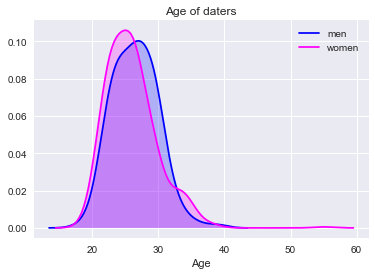

In [34]:
sns.kdeplot(data[data.gender == 1].age,
            bw=1.5, shade=True, color='blue', label='men')
sns.kdeplot(data[data.gender == 0].age,
            bw=1.5, shade=True, color='magenta', label='women')
plt.title('Age of daters')
plt.xlabel('Age');

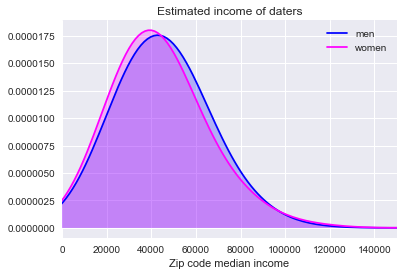

In [35]:
sns.kdeplot(data[(data.gender == 1) & (data.income > 0)].income,
            bw=15000, shade=True, color='blue', label='men')
sns.kdeplot(data[(data.gender == 0) & (data.income > 0)].income,
            bw=15000, shade=True, color='magenta', label='women')
plt.title('Estimated income of daters')

plt.xlim(0,150000)
plt.xlabel('Zip code median income')

# Trying Different Classifiers

I did some experimentation with adjusting the hyperparameters of each model below. Each score is fairly representative of the algorithm's best performance.

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV

x = data.drop('match', axis=1)
y = data['match']

# Fixing a csv import bug
for i in x.columns:
    if 'Unnamed' in i:
        del x[i]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2)

xtrain.shape

(4608, 418)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1,9,2)}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') 

Mean score: 0.606812676569
Std Dev:    0.0142035749395


In [38]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Mean score: 0.671138375121
Std Dev:    0.0327511545135


In [39]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
params = {'penalty': ['l1', 'l2'],
         'C': [.1, 1, 1,]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Mean score: 0.831994349784
Std Dev:    0.00988481585769


In [40]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
params = {'max_depth': list(np.arange(2,13)) + [None],
         'min_samples_leaf': [1,2,3,4,5,6,7,10]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Mean score: 0.798855886378
Std Dev:    0.0181546322247


In [41]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
params = {'max_depth': list(np.arange(3,10)) + [None],
         'min_samples_leaf': [1,2,3],
         'n_estimators': [10,100]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Mean score: 0.813491822636
Std Dev:    0.0113182351142


In [42]:
from xgboost import XGBClassifier

clf = XGBClassifier()
params = {'max_depth': list(np.arange(2, 9)),
         'reg_lambda': np.arange(1, 2.5, .25),
         'n_estimators': [100]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.25, scale_pos_weight=1, seed=0,
       silent=True, subsample=1) 

Mean score: 0.876728447515
Std Dev:    0.00206314185545


In [43]:
from xgboost import XGBClassifier

clf = XGBClassifier()
params = {'max_depth': list(np.arange(2,5)),
         'reg_lambda': np.arange(1, 1.5, .1),
         'n_estimators': [100, 200, 300]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.3000000000000003, scale_pos_weight=1,
       seed=0, silent=True, subsample=1) 

Mean score: 0.877860973779
Std Dev:    0.00345906535399


# Dimensionality Reduction & Grid Search

Now's a good time for us to use GridSearchCV to find the best model. I tested two methods of dimensionality reduction: **principal component analysis** and **SelectPercentile**. The latter, which only uses the most important features to make predictions, was significantly more effective.

Therefore, we'll create a pipeline that combines SelectPercentile with XGBoost, one of the better algorithms we found.

I probably spent around 100 hours performing a more exhaustive grid search, so the parameters below are provided as an example and should allow us to quickly load up the best settings I found.

In [7]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV, train_test_split

pl = Pipeline([
    ('reduce_dim', SelectPercentile()),
    ('classify', XGBClassifier())
])

# Recall that I've run this notebook multiple times
# and did a MUCH more exhaustive search previously.
PERC_OPTIONS = np.arange(52,56,2) # It consistently settles on a value around 50-55
EST_OPTIONS = [100] # Best setting I found; we'll only use this to save time
DEPTH_OPTIONS = [3]
LAM_OPTIONS = np.arange(1.2, 1.5, .1)

param_grid = [
    {
        'reduce_dim__percentile': PERC_OPTIONS,
        'classify__n_estimators': EST_OPTIONS,
        'classify__reg_lambda': LAM_OPTIONS,
        'classify__max_depth': DEPTH_OPTIONS,
    },
]

grid =\
GridSearchCV(pl, cv=3, n_jobs=-1, param_grid=param_grid, scoring='roc_auc')\
.fit(xtrain, ytrain)

model = grid.best_estimator_

In [8]:
model.named_steps['classify']

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.3, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [9]:
model.named_steps['reduce_dim']

SelectPercentile(percentile=54,
                 score_func=<function f_classif at 0x000001262761EB88>)

In [47]:
cv = cross_val_score(model, xtrain, ytrain, cv=4, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Mean score: 0.876255297078
Std Dev:    0.00240131790003


Drumroll, please... time to see how the model performs!

In [10]:
pred = model.predict_proba(xtest)[:, 1]

roc_auc_score(ytest, pred)

0.8637352968417153

# Sensitivity Analysis

How robust is our model? Let's test it by randomizing data and seeing how well it continues to classify.

In [62]:
from random import choice

def sensitivity_analysis(x=x, clf=model, cols=10, print_scrambled=False):
    '''
    Randomizes the data for a set number of columns
    '''
    cv_scores = []
    
    # Average over 5 times
    for i in range(5):
        x_sens = x.copy()
        scrambled = set()
        while len(scrambled) < cols:
            col_to_scramble = choice(x_sens.columns)
            scrambled.add(col_to_scramble)
            x_sens[col_to_scramble] = np.random.randn(len(x_sens))
        if print_scrambled:
            print('Scrambed:', scrambled)
        cv_scores.append(cross_val_score(clf, x_sens, y, cv=4, scoring='roc_auc').mean())
        
    print('Average cross val score ({} columns scrambled):'.format(cols), np.mean(cv_scores))

In [50]:
sensitivity_analysis(cols=10)

Average cross val score (10 columns scrambled): 0.87460033245


In [51]:
sensitivity_analysis(cols=20)

Average cross val score (20 columns scrambled): 0.870479793477


In [52]:
sensitivity_analysis(cols=50)

Average cross val score (50 columns scrambled): 0.868393342225


In [53]:
sensitivity_analysis(cols=100)

Average cross val score (100 columns scrambled): 0.854763682717


In [54]:
sensitivity_analysis(cols=200)

Average cross val score (200 columns scrambled): 0.790495102291


In [55]:
sensitivity_analysis(cols=400)

Average cross val score (400 columns scrambled): 0.549467413906


# Final Analyses

Let's see how the classifier cross-validates with the entire dataset.

In [56]:
cv = cross_val_score(model, x, y, cv=4, scoring='roc_auc')

print('Mean roc_auc: {0:.4f} (Std dev: {1:.4f})'.format(cv.mean(),  cv.std()))

Mean roc_auc: 0.8754 (Std dev: 0.0117)


This performance is phenomenal, IMO! Let's visualize it using this code from sklearn's documentation:

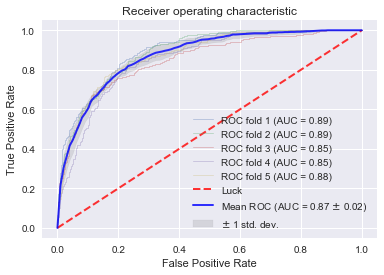

In [63]:
# Need to fix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc

cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
x2 = x.values
y2 = y.values
i = 0
for train, test in cv.split(x2, y2):
    probas_ = model.fit(x2[train], y2[train]).predict_proba(x2[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

One of my data science mentors suggests looking at the true positive rate when the false positive rate equals 50%.

- A true positive rate above 70% can be considered "good,"
- A true positive rate above 80% is "really good," and...
- A true positive rate above 90% is "too good"  -- your model might be leaking information from the future.

By those standards, this model is a little *too* good. Having spent a lot of time with this data, I know this is because of the "desirability" and "choosiness" features I added.

While I stand by the assertion that these are valid features and a dating app would have similar data, I think it's still worth running this analysis one more time *without* them. This is how well we could expect the algorithm to work for new users.

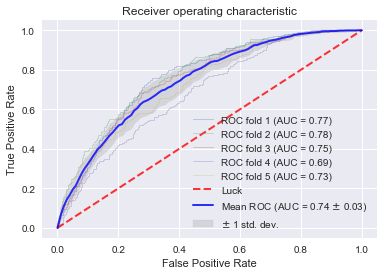

In [64]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
x2 = x[[i for i in x.columns if 'desirability' not in i and 'choosiness' not in i]].values
y2 = y.values
i = 0
for train, test in cv.split(x2, y2):
    probas_ = model.fit(x2[train], y2[train]).predict_proba(x2[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Now we're in the 80-90% range, and it's fair to say this is still a really good model.

Next, let's look at which features were most important in predicting matches.

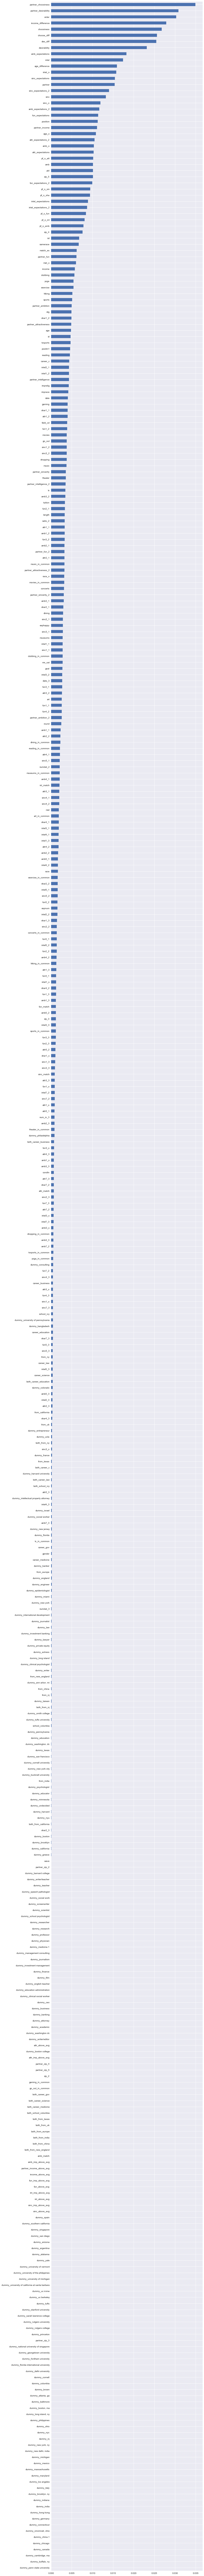

In [60]:
# For simplicity's sake, we'll train a new XGBoost classifier
xg = XGBClassifier(max_depth=12, n_estimators=400).fit(x,y)

fig, ax = plt.subplots(figsize=(12, len(x.columns)//2))

importances = pd.Series(xg.feature_importances_,
                        index=x.columns).sort_values(ascending=True)

importances.plot.barh()

Some observations:

- Of the top 10 features, 8 were features I engineered. This is something I can be proud of -- it shows that I cracked the code of matchmaking!

- Whether someone was met earlier or later in the speed dating event influenced how likely a match was. The correlation is -0.04, which is miniscule. My hypothesis for this is that people got mentally exhausted as the event dragged on and started defaulting to a "no" answer. We'd need to design a separate experiment to prove this, but a famous study found that [judges were less likely to grant parole](https://www.wired.com/2011/04/judges-mental-fatigue/) as it got closer to lunch time!

- The model learned the idiosyncracies of specific daters to predict matches. This probably means that certain people were highly desirable and not especially selective. If I were to gather new data, I'd find a way to represent this in terms of one's personality and dating expectations (as someone with domain expertise, this wouldn't be especially difficult for me).

- The "expectation" features I engineered turned out to be quite useful, while a lot of the dummified features were not.

Be sure to read the accompanying report for further insights and explanations. I hope you've enjoyed exploring this data with me!